#  Time Series Forecasting using Prophet
![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

In this notebook we apply fbprophet for a sample problem.

# Introduction for Prophet

Two main themes in the practice of
creating business forecasts:- 
1. completely automatic forecasting techniques can be hard
to tune and are often too inflexible to incorporate useful assumptions or heuristics. 

2. the analysts responsible for data science tasks throughout an organization typically have
deep domain expertise about the specific products or services that they support, but often
do not have training in time series forecasting. 



### Prophet model

prphet uses a decomposable time series model with three main
model components: trend, seasonality, and holidays.
$$ y(t) = g(t)+s(t)+h(t)+\epsilon_t$$

g(t) is the trend function which models non-periodic changes

s(t) represents periodic changes

h(t) represents the effects of holidays

The error term $\epsilon_t$ represents any idiosyncratic changes

The trend model has two compnents: Saturating Growth modeled as a picewise logistic function and, Linear Growth, both incorporate a growth rate that changes at times we call changepoints. Saturating Growth has a time-varying capacity term that gives maximum possible value of that component. 

Seasonality model is modeled as a fourier series with multiple Periodicities for weekly, monthly as well as yearly seasonlity. 


#### advantages
1. Prophet makes it much more straightforward to create a reasonable, accurate forecast
2. Prophet forecasts are customizable in ways that are intuitive to non-experts who have deep domain experience but inadequate expertise in statistical modelling.


#### Analyst-in-the-loop Approach

![alt text](AnaloopProphet.png)

by combining automatic forecasting with analyst-in-the-loop forecasts for special cases, it is possible to cover a wide variety of business use-cases. 

In the Prophet model specification there
are several places where analysts can alter the model to apply their expertise and external
knowledge without requiring any understanding of the underlying statistics.

1. Changepoints:Known dates of changepoints, such as dates of product changes can be fed to model.
2. Capacities: based on market size and other factors can determine Capacity and input to model
3. Holidays: Based on region can directly input holiday dates.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Importing plotly failed. Interactive plots will not work.


# Data
The data we will be using is hourly power consumption data.


In [2]:
pjme = pd.read_csv('./PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

In [4]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


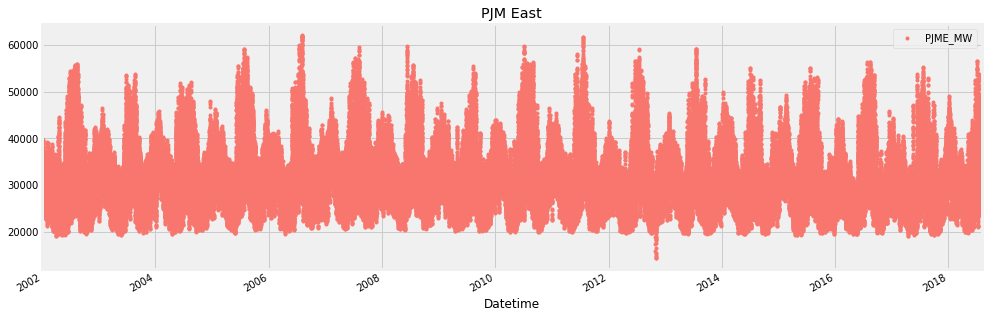

In [3]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

# EDA

We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [5]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [6]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends
- Power demand has strong daily and seasonal properties.
- Day of week also seems to show differences in peaks

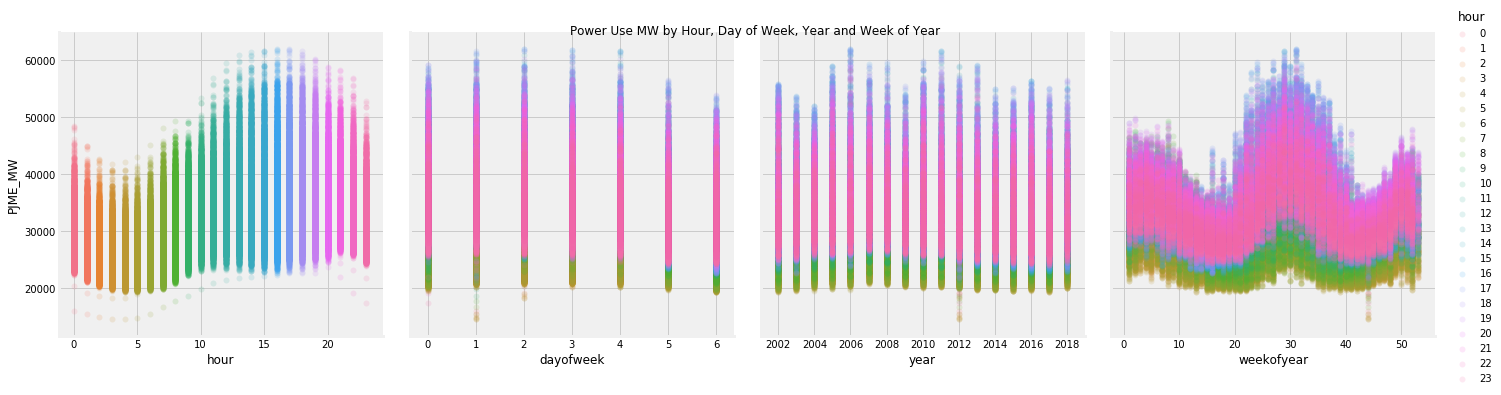

In [7]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

# Train/Test Split
Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [10]:
split_date = '01-Jan-2016'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

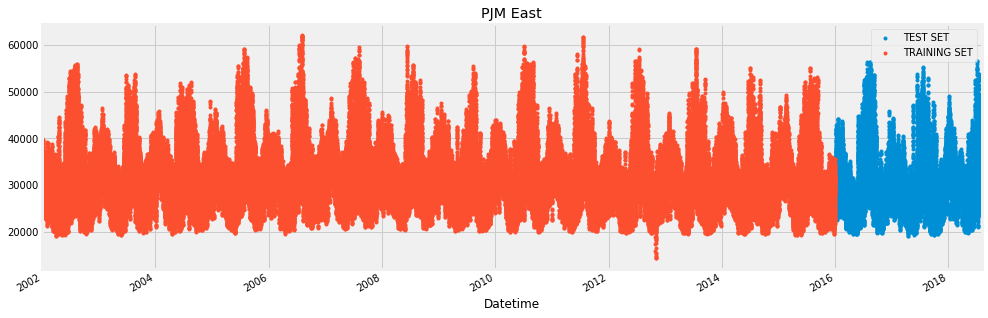

In [11]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [12]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [13]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

In [14]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [15]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01 01:00:00,31224.535642,23292.070895,32394.958237,31224.535642,31224.535642,-3280.315485,-3280.315485,-3280.315485,-4410.349703,...,924.244482,924.244482,924.244482,205.789736,205.789736,205.789736,0.0,0.0,0.0,27944.220158
1,2016-01-01 02:00:00,31224.504764,21802.983835,30944.212937,31224.504764,31224.504764,-4780.874488,-4780.874488,-4780.874488,-5899.288131,...,910.189493,910.189493,910.189493,208.224151,208.224151,208.224151,0.0,0.0,0.0,26443.630277
2,2016-01-01 03:00:00,31224.473887,21058.402294,29860.157398,31224.473887,31224.473887,-5653.100303,-5653.100303,-5653.100303,-6758.550345,...,894.750972,894.750972,894.750972,210.699070,210.699070,210.699070,0.0,0.0,0.0,25571.373584
3,2016-01-01 04:00:00,31224.443009,20695.204947,29963.205508,31224.443009,31224.443009,-5797.953893,-5797.953893,-5797.953893,-6888.759049,...,877.590666,877.590666,877.590666,213.214491,213.214491,213.214491,0.0,0.0,0.0,25426.489116
4,2016-01-01 05:00:00,31224.412131,21611.104577,31069.431883,31224.412131,31224.412131,-5129.515031,-5129.515031,-5129.515031,-6203.638670,...,858.353233,858.353233,858.353233,215.770407,215.770407,215.770407,0.0,0.0,0.0,26094.897099


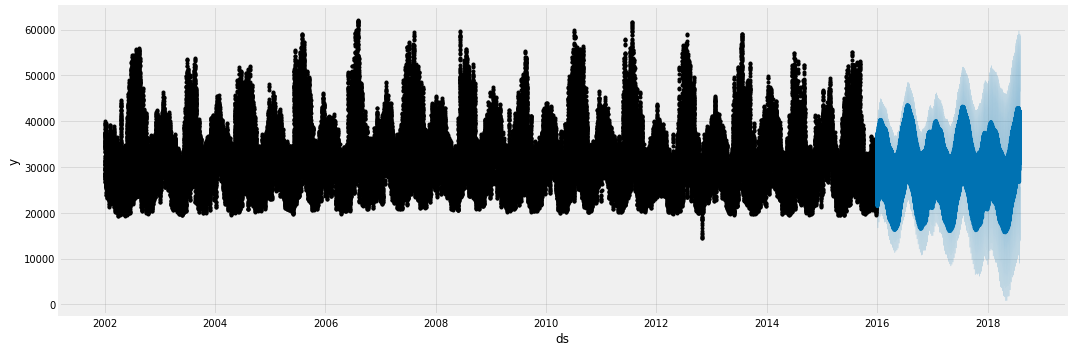

In [16]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

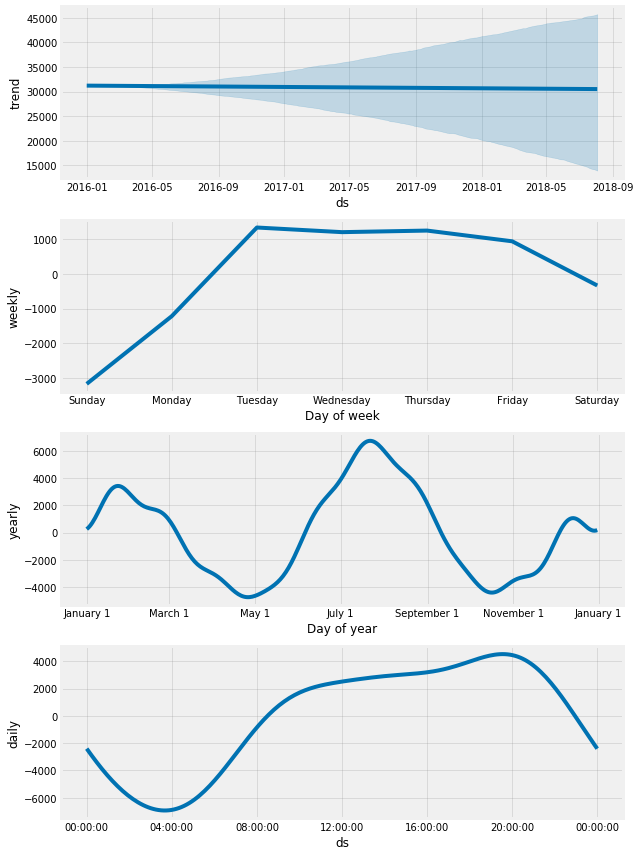

In [17]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

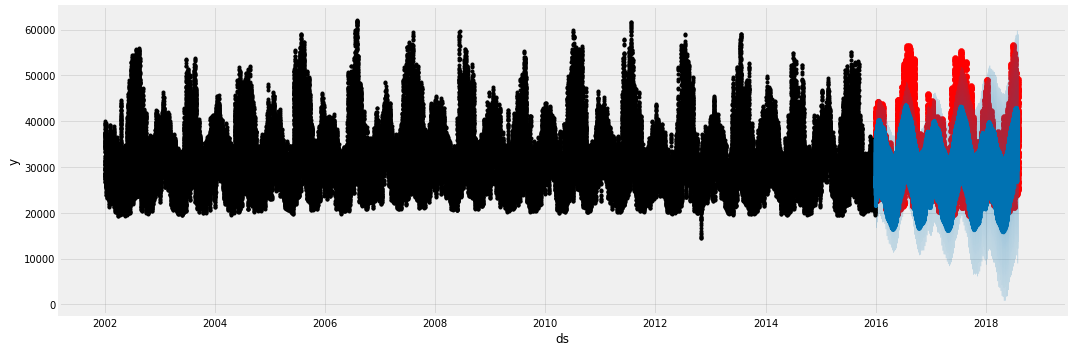

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Look at first month of predictions

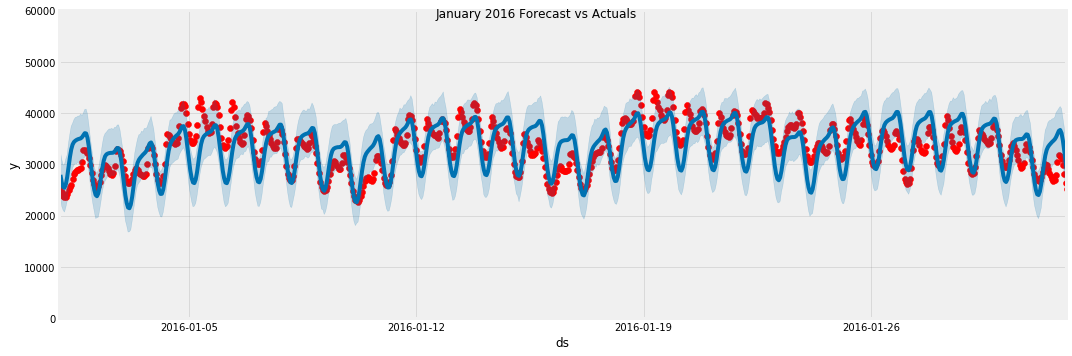

In [27]:
# Plot the forecast with the actuals
from datetime import datetime
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('01-01-2016','%d-%m-%Y').date(),
              upper=datetime.strptime('01-02-2016','%d-%m-%Y').date())
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2016 Forecast vs Actuals')

# Single Week of Predictions

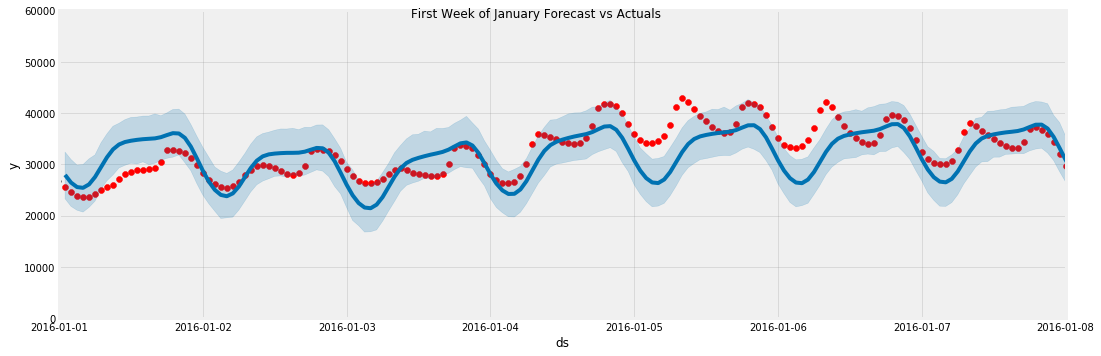

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('01-01-2016','%d-%m-%Y').date(), upper=datetime.strptime('08-01-2016','%d-%m-%Y').date())
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Error Metrics

In [29]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

39774234.097972795

In [30]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

4919.208202172918

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

15.843337114673009

# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [33]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [34]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [35]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

## Predict With Holidays

In [36]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## Plot Holiday Effect

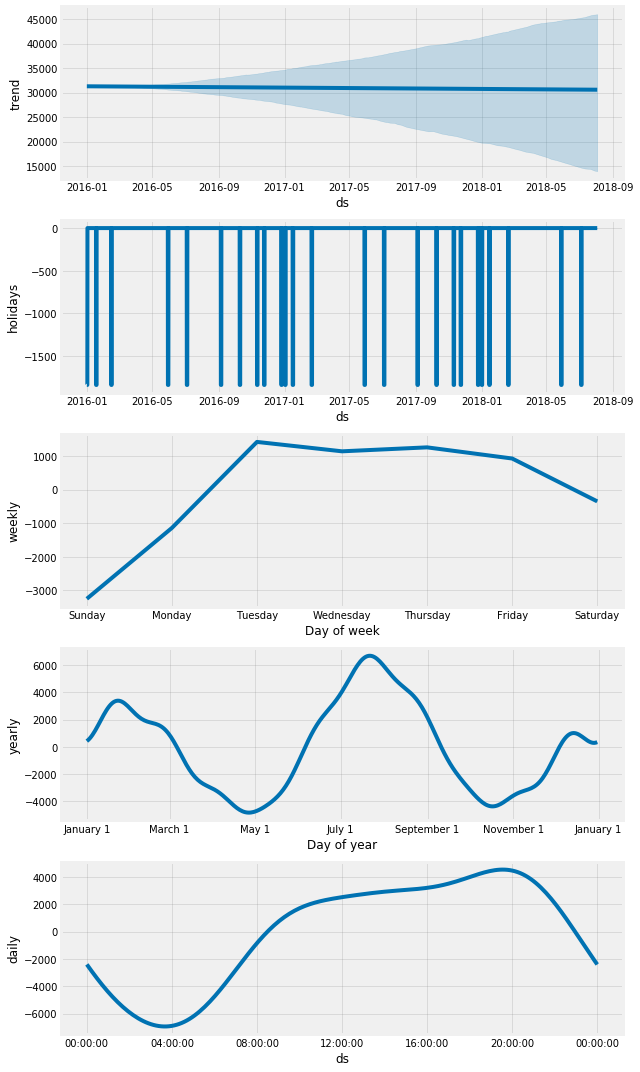

In [37]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Error Metrics with Holidays Added
Suprisingly the error has gotten worse after adding holidays.

In [38]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

39885422.33145533

In [39]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

4927.804185092546

In [40]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

15.877439070367421

# Compare Models Just for Holiday Dates
Lets plot Forecast model with and without holidays for 4th of July. It does look like the model with holidays is more accurate for this holiday.

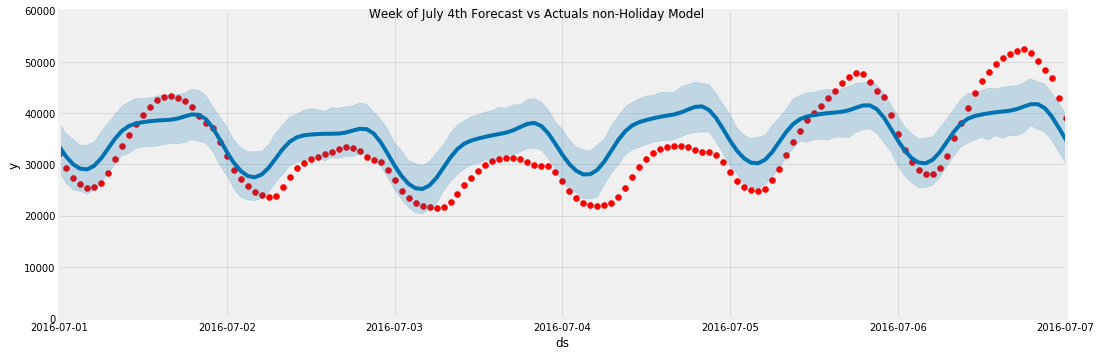

In [43]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('01-07-2016','%d-%m-%Y').date(), upper=datetime.strptime('07-07-2016','%d-%m-%Y').date())
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

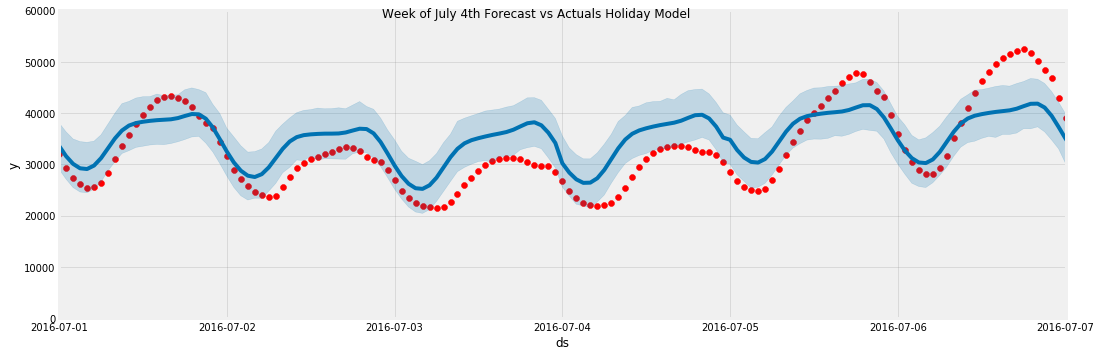

In [44]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower=datetime.strptime('01-07-2016','%d-%m-%Y').date(), upper=datetime.strptime('07-07-2016','%d-%m-%Y').date())
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

## Compare Error for just 4th of July
The error has gone down for this date.

In [45]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [46]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2184.4883705187444

In [47]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2184.5978975133207

# Error of all Holidays
- Holiday error has gone up! This is unexpected.

In [48]:
holiday_list = holiday_df['ds'].tolist()

In [49]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')

In [50]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5137.678719518982

In [51]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

4982.949941348776

# Identify Error by holiday
- We can see different holidays respond differently in this model. The model would perform better if we specifically identify holidays instead of lumping them all together as "USFederalHolidays"

In [52]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2016:    
 MAE (non-holiday model): 4090.8 
 MAE (Holiday Model): 2500.1 
 Diff 1590.7
Holiday: January 18, 2016:    
 MAE (non-holiday model): 2927.9 
 MAE (Holiday Model): 4341.4 
 Diff -1413.5
Holiday: February 15, 2016:    
 MAE (non-holiday model): 6205.6 
 MAE (Holiday Model): 7793.3 
 Diff -1587.8
Holiday: May 30, 2016:    
 MAE (non-holiday model): 1552.1 
 MAE (Holiday Model): 2780.5 
 Diff -1228.3
Holiday: July 04, 2016:    
 MAE (non-holiday model): 7506.4 
 MAE (Holiday Model): 5875.7 
 Diff 1630.6
Holiday: September 05, 2016:    
 MAE (non-holiday model): 3596.5 
 MAE (Holiday Model): 2422.8 
 Diff 1173.7
Holiday: October 10, 2016:    
 MAE (non-holiday model): 2313.9 
 MAE (Holiday Model): 1878.7 
 Diff 435.2
Holiday: November 11, 2016:    
 MAE (non-holiday model): 2182.7 
 MAE (Holiday Model): 1685.6 
 Diff 497.1
Holiday: November 24, 2016:    
 MAE (non-holiday model): 3676.8 
 MAE (Holiday Model): 2771.2 
 Diff 905.6
Holiday: December 26, 2016:   

# Plot Error of Each Forecast
- We can see that both of our models generalize well, but struggle with peak demand days.
- Seems to be under forecasting many days.

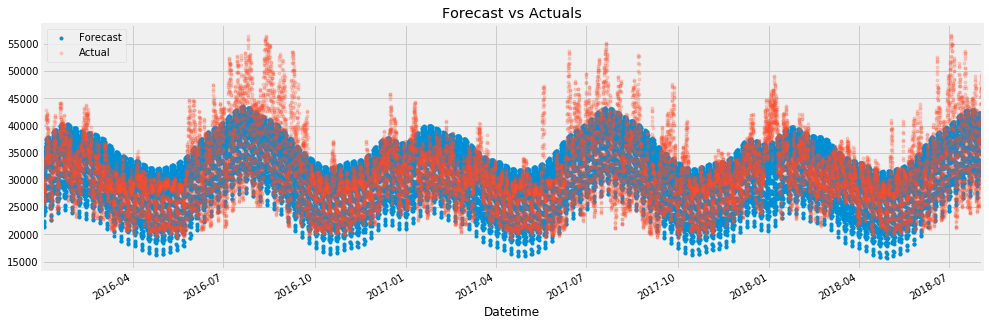

In [53]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()